# Import packages and load data

In [2]:
import msgspec
import pandas as pd
import numpy as np
import ast
from collections import Counter
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from gensim.models import Word2Vec
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Warnings
import warnings
### Text Preprocessing and Natural Language Processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
import re
from wordcloud import WordCloud

## Sampling and Filtering

### Dataset 1: Business (From Yelp)

In [5]:
def stream_jsonl(filename):
    with open(filename, "r", encoding="utf-8") as file:
        for i, line in enumerate(file):
            yield msgspec.json.decode(line.strip())


# Convert streamed data to a Pandas DataFrame
business_data_raw = pd.DataFrame(stream_jsonl(
    "yelp_academic_dataset_business.json"))
print("Dataframe Shape:", business_data_raw.shape)
business_data_raw.head(3)

Dataframe Shape: (150346, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


In [6]:
business_data_raw.info()
business_data_raw.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


,latitude,longitude,stars,review_count,is_open
count,150346.00,150346.00,150346.00,150346.00,150346.0
mean,36.67,-89.36,3.60,44.87,0.8
std,5.87,14.92,0.97,121.12,0.4
min,27.56,-120.10,1.00,5.00,0.0
25%,32.19,-90.36,3.00,8.00,1.0
50%,38.78,-86.12,3.50,15.00,1.0
75%,39.95,-75.42,4.50,37.00,1.0
max,53.68,-73.20,5.00,7568.00,1.0


#### Filtering for Active Restaurants
Retained only businesses where is_open equals to 1, ensuring that the recommendation system suggests operational restaurants.

In [8]:
biz = business_data_raw[business_data_raw['is_open'] == 1].copy()
biz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119698 entries, 1 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   119698 non-null  object 
 1   name          119698 non-null  object 
 2   address       119698 non-null  object 
 3   city          119698 non-null  object 
 4   state         119698 non-null  object 
 5   postal_code   119698 non-null  object 
 6   latitude      119698 non-null  float64
 7   longitude     119698 non-null  float64
 8   stars         119698 non-null  float64
 9   review_count  119698 non-null  int64  
 10  is_open       119698 non-null  int64  
 11  attributes    107350 non-null  object 
 12  categories    119603 non-null  object 
 13  hours         103603 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 13.7+ MB


#### Focusing on Pennsylvania (PA)
Since Pennsylvania had the highest representation in the dataset, we filtered businesses to include only those within PA, allowing for a well-defined geographic scope.

In [10]:
biz.groupby("state")["business_id"].count().sort_values(ascending=False)

state
PA     26289
FL     21540
TN      9600
IN      8946
MO      8363
AZ      8108
LA      7676
NJ      7031
NV      6277
AB      4346
CA      4065
ID      3783
DE      1894
IL      1765
TX         4
WA         2
MA         2
VT         1
UT         1
MI         1
SD         1
HI         1
CO         1
XMS        1
Name: business_id, dtype: int64

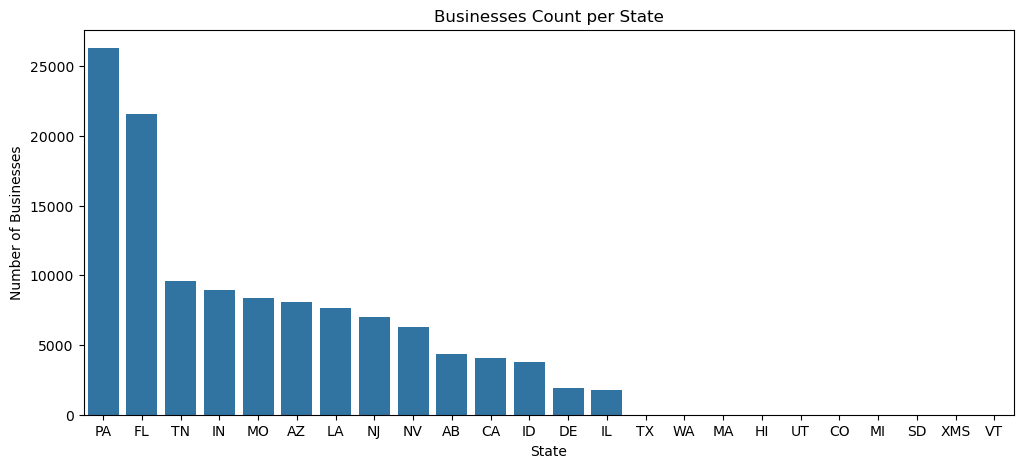

In [11]:
state_counts = biz['state'].value_counts()
plt.figure(figsize=(12, 5))
sns.barplot(x=state_counts.index, y=state_counts.values)
plt.xlabel("State")
plt.ylabel("Number of Businesses")
plt.title("Businesses Count per State")
plt.show()

In [12]:
# Get businesses in most popular state
biz = biz[biz['state'] == "PA"]
print("Filtered Business Shape (Open & PA):", biz.shape)
biz.head(3)

Filtered Business Shape (Open & PA): (26289, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."


#### Extracting Restaurants Businesses
Since our project is a restaurant recommendation system, we extracted restaurant businesses.

When looking through the unique business categories with "restaurant", we noticed that there were other categories "Restaurant Supplies" and "Pop-Up Restaurants". To ensure we only extract restaurant businesses (not the "Restaurant Supplies" category), we filtered for businesses that have "Restaurants" as a standalone category.

In [14]:
# Count occurrences of each restaurant-related category, handling NaN values
restaurant_category_counts = biz['categories'].dropna().str.split(', ').explode()
restaurant_category_counts = restaurant_category_counts[restaurant_category_counts.str.lower().str.contains('restaurant', na=False)].value_counts()
print("Count of Each Restaurant-Related Category:")
print(restaurant_category_counts)

Count of Each Restaurant-Related Category:
categories
Restaurants            8069
Pop-Up Restaurants       10
Restaurant Supplies       5
Name: count, dtype: int64


In [15]:
biz = biz[['business_id', 'name', 'city', 'postal_code', 'categories', 'attributes', 'stars']]

# Get only restaurants
restaurants = biz[biz['categories'].str.contains(
    'Restaurants') == True].reset_index()

# Ensure attributes is always a dictionary
restaurants["attributes"] = restaurants["attributes"].apply(
    lambda x: x if isinstance(x, dict) else {})

# Normalize attributes column
attributes_df = pd.json_normalize(restaurants["attributes"])

# Concatenate the main dataframe with the expanded attributes
restaurants = restaurants.drop(columns=["attributes"]).join(attributes_df)

for att in ["Alcohol", "WiFi", "RestaurantsAttire", "NoiseLevel", "BYOBCorkage", "AgesAllowed", "Smoking"]:
    restaurants[att] = restaurants[att].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

restaurants['RestaurantsPriceRange2'] = pd.to_numeric(
    restaurants['RestaurantsPriceRange2'], errors='coerce')

for att in ["Ambience", "BusinessParking", "GoodForMeal", "Music", "BestNights", "DietaryRestrictions"]:
    restaurants[att] = restaurants[att].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    restaurants[att] = restaurants[att].apply(
        lambda x: ", ".join([k for k, v in x.items() if v]
                            ) if isinstance(x, dict) else ""
    )
    

def clean_values(x):
    """Cleans and standardizes values across columns."""
    if isinstance(x, str):
        x_lower = x.strip().lower()
        if x_lower in ["true"]:
            return True
        elif x_lower in ["false"]:
            return False
        elif x_lower in ["none", "nan", "null", ""]:
            return np.nan  # Convert both "None" and "nan" strings to pd.NA
        return x  # Keep other strings unchanged
    elif pd.isna(x) or x is None:
        return np.nan  # Convert NaN and None to pd.NA
    return x  # Keep other values unchanged

# Apply cleaning function to all columns
restaurants = restaurants.apply(lambda col: col.map(clean_values))

# Drop columns
restaurants = restaurants.drop(columns=['index'])

pd.set_option("display.max_columns", None)
print("Filtered Restaurant Businesses Shape:", restaurants.shape)
restaurants.head()

Filtered Restaurant Businesses Shape: (8069, 44)


,business_id,name,city,postal_code,categories,stars,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,RestaurantsReservations,RestaurantsGoodForGroups,RestaurantsAttire,HasTV,Ambience,GoodForKids,GoodForMeal,NoiseLevel,DogsAllowed,HappyHour,WheelchairAccessible,RestaurantsTableService,Smoking,CoatCheck,Music,BYOB,BusinessAcceptsBitcoin,BestNights,GoodForDancing,DriveThru,BYOBCorkage,Corkage,Open24Hours,AgesAllowed,AcceptsInsurance,RestaurantsCounterService,DietaryRestrictions
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,19107,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,False,False,False,street,True,1.0,True,False,free,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,19106,"Sushi Bars, Restaurants, Japanese",4.0,True,True,True,street,NaN,2.0,True,NaN,free,full_bar,NaN,True,True,casual,False,classy,False,"dessert, dinner",average,False,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ROeacJQwBeh05Rqg7F6TCg,BAP,Philadelphia,19147,"Korean, Restaurants",4.5,NaN,NaN,True,street,True,1.0,True,NaN,no,NaN,True,False,False,casual,True,casual,True,"lunch, dinner",quiet,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,kV_Q1oqis8Qli8dUoGpTyQ,Ardmore Pizza,Ardmore,19003,"Pizza, Restaurants",3.5,True,False,True,"street, lot",True,1.0,True,NaN,no,NaN,True,False,True,casual,True,casual,True,"latenight, dinner",average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,Philadelphia,19123,"Eatertainment, Arts & Entertainment, Brewpubs,...",3.5,True,True,True,lot,NaN,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,classy,True,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
for col in restaurants.iloc[:, 6:].columns:
    unique_values = restaurants[col].unique()  # Get unique values
    print(f"{col}: {unique_values}")

RestaurantsDelivery: [False True nan]
OutdoorSeating: [False True nan]
BusinessAcceptsCreditCards: [False True nan]
BusinessParking: ['street' 'street, lot' 'lot' nan 'garage, street' 'lot, valet'
 'garage, street, validated, lot' 'street, lot, valet'
 'garage, street, lot' 'street, valet' 'garage, validated'
 'garage, street, validated, lot, valet' 'validated'
 'garage, street, valet' 'garage, lot' 'garage' 'valet'
 'street, validated, valet' 'garage, street, validated, valet'
 'garage, street, validated' 'street, validated' 'validated, valet'
 'garage, lot, valet' 'validated, lot' 'garage, valet'
 'street, validated, lot' 'garage, validated, lot' 'valet, lot'
 'street, validated, lot, valet']
BikeParking: [True nan False]
RestaurantsPriceRange2: [ 1.  2. nan  3.  4.]
RestaurantsTakeOut: [True nan False]
ByAppointmentOnly: [False nan True]
WiFi: ['free' 'no' nan 'paid']
Alcohol: [nan 'full_bar' 'beer_and_wine']
Caters: [True nan False]
RestaurantsReservations: [nan True False]
Restaur

In [17]:
sorted_columns = restaurants.count().sort_values(ascending=False).index
restaurants = restaurants[sorted_columns]
restaurants.info()
restaurants.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8069 entries, 0 to 8068
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 8069 non-null   object 
 1   city                        8069 non-null   object 
 2   postal_code                 8069 non-null   object 
 3   categories                  8069 non-null   object 
 4   stars                       8069 non-null   float64
 5   name                        8069 non-null   object 
 6   RestaurantsTakeOut          7471 non-null   object 
 7   BusinessAcceptsCreditCards  7181 non-null   object 
 8   RestaurantsDelivery         7149 non-null   object 
 9   RestaurantsPriceRange2      6581 non-null   float64
 10  RestaurantsReservations     6376 non-null   object 
 11  HasTV                       6366 non-null   object 
 12  OutdoorSeating              6192 non-null   object 
 13  RestaurantsGoodForGroups    6004 

,stars,RestaurantsPriceRange2
count,8069.00,6581.00
mean,3.56,1.59
std,0.81,0.59
min,1.00,1.00
25%,3.00,1.00
50%,3.50,2.00
75%,4.00,2.00
max,5.00,4.00


### Dataset 2: Reviews (From Yelp)

In [19]:
# Convert streamed data to a Pandas DataFrame
review_data_raw = pd.DataFrame(stream_jsonl(
    "yelp_academic_dataset_review.json"))
print("Dataframe Shape:", review_data_raw.shape)
review_data_raw.head(3)

Dataframe Shape: (6990280, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30


#### Filtering for businesses in restaurants dataset

In [21]:
pa_restaurant_ids = set(restaurants['business_id'])
pa_reviews = review_data_raw[review_data_raw['business_id'].isin(pa_restaurant_ids)].copy()
print("Filtered Pennsylvania Reviews Shape:", pa_reviews.shape)
pa_reviews.head(3)

Filtered Pennsylvania Reviews Shape: (836680, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25


In [22]:
pa_reviews.info()
pa_reviews.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
Index: 836680 entries, 0 to 6990272
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    836680 non-null  object 
 1   user_id      836680 non-null  object 
 2   business_id  836680 non-null  object 
 3   stars        836680 non-null  float64
 4   useful       836680 non-null  int64  
 5   funny        836680 non-null  int64  
 6   cool         836680 non-null  int64  
 7   text         836680 non-null  object 
 8   date         836680 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 63.8+ MB


,stars,useful,funny,cool
count,836680.00,836680.00,836680.00,836680.00
mean,3.79,1.05,0.34,0.49
std,1.36,2.48,1.39,1.84
min,1.00,0.00,0.00,0.00
25%,3.00,0.00,0.00,0.00
50%,4.00,0.00,0.00,0.00
75%,5.00,1.00,0.00,0.00
max,5.00,224.00,227.00,163.00


In [23]:
# Change date to datetime format for describe() to work
pa_reviews['date'] = pd.to_datetime(pa_reviews['date'])
pa_reviews.info()
pa_reviews.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
Index: 836680 entries, 0 to 6990272
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    836680 non-null  object        
 1   user_id      836680 non-null  object        
 2   business_id  836680 non-null  object        
 3   stars        836680 non-null  float64       
 4   useful       836680 non-null  int64         
 5   funny        836680 non-null  int64         
 6   cool         836680 non-null  int64         
 7   text         836680 non-null  object        
 8   date         836680 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 63.8+ MB


,stars,useful,funny,cool,date
count,836680.00,836680.00,836680.00,836680.00,836680
mean,3.79,1.05,0.34,0.49,2016-09-25 13:15:53.063883008
min,1.00,0.00,0.00,0.00,2005-02-16 04:06:26
25%,3.00,0.00,0.00,0.00,2014-08-01 07:33:11.500000
50%,4.00,0.00,0.00,0.00,2017-03-06 22:38:15.500000
75%,5.00,1.00,0.00,0.00,2019-04-10 12:23:19.249999872
max,5.00,224.00,227.00,163.00,2022-01-19 19:46:34
std,1.36,2.48,1.39,1.84,NaN


### Dataset 3: Users (From Yelp)

In [25]:
# Convert streamed data to a Pandas DataFrame
user_data_raw = pd.DataFrame(stream_jsonl(
    "yelp_academic_dataset_user.json"))
print("Dataframe Shape:", user_data_raw.shape)
user_data_raw.head(3)

Dataframe Shape: (1987897, 22)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,3.91,250,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,3.32,89,13,10,17,3,66,96,119,119,35,18


#### Filtering users who reviewed businesses in restaurants dataset

In [27]:
valid_user_ids = set(pa_reviews['user_id'])
filtered_users = user_data_raw[user_data_raw['user_id'].isin(valid_user_ids)]

print("Filtered User Data Shape:", filtered_users.shape)
filtered_users.head(3)

Filtered User Data Shape: (269461, 22)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,3.91,250,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946
5,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,3.85,1713,163,191,361,147,1212,5696,2543,2543,815,323


In [28]:
filtered_users.info()
filtered_users.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
Index: 269461 entries, 0 to 1987892
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             269461 non-null  object 
 1   name                269461 non-null  object 
 2   review_count        269461 non-null  int64  
 3   yelping_since       269461 non-null  object 
 4   useful              269461 non-null  int64  
 5   funny               269461 non-null  int64  
 6   cool                269461 non-null  int64  
 7   elite               269461 non-null  object 
 8   friends             269461 non-null  object 
 9   fans                269461 non-null  int64  
 10  average_stars       269461 non-null  float64
 11  compliment_hot      269461 non-null  int64  
 12  compliment_more     269461 non-null  int64  
 13  compliment_profile  269461 non-null  int64  
 14  compliment_cute     269461 non-null  int64  
 15  compliment_list     269461 non-null  i

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00
mean,38.28,81.85,34.74,49.43,2.85,3.66,3.55,0.54,0.36,0.24,0.14,3.03,6.12,5.64,5.64,2.09,2.50
std,140.04,1150.74,775.49,1019.21,36.12,1.06,119.88,14.75,20.74,9.16,8.02,145.58,239.22,164.63,164.63,52.32,146.24
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.00,0.00,0.00,0.00,3.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,8.00,4.00,1.00,1.00,0.00,3.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,24.00,20.00,4.00,5.00,1.00,4.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,17473.00,206296.00,185823.00,199878.00,12497.00,5.00,25784.00,4347.00,7039.00,2974.00,2607.00,59031.00,101097.00,49967.00,49967.00,15934.00,56104.00


In [29]:
print("Unique Users in Review Data:", pa_reviews['user_id'].nunique())
print("Unique Users in User Data:", filtered_users['user_id'].nunique())

Unique Users in Review Data: 269462
Unique Users in User Data: 269461


#### Observation 1: Missing User Entries
After filtering, we observed that one user (user_id 'MaengE6zJ6k_d5e6nwnVaA') in the review dataset, was not found in the user dataset. His review was dated 2022-01-19, which was the maximum date in the review dataset.

In [31]:
# Find users in review dataset but not in user dataset
users_not_in_user_dataset = set(pa_reviews['user_id']) - set(user_data_raw['user_id'])

print("Number of Users in Review Dataset but Not in User Dataset:", len(users_not_in_user_dataset))
if len(users_not_in_user_dataset) > 0:
    print("Sample Missing Users:", list(users_not_in_user_dataset)[:5])

Number of Users in Review Dataset but Not in User Dataset: 1
Sample Missing Users: ['MaengE6zJ6k_d5e6nwnVaA']


In [32]:
missing_user_reviews = pa_reviews[pa_reviews['user_id'].isin(users_not_in_user_dataset)]
missing_user_reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
2076660,GZmjLeVfDktqx7xZvAHBSg,MaengE6zJ6k_d5e6nwnVaA,kZTwub3IkBCDHYW5J5pRrA,1.0,0,0,0,Ordered 2 meatball park sandwiches both sandwi...,2022-01-19 17:45:25


With this, we conducted a deeper analysis of the raw review and user datasets and found that 32 users who made their first review on 2022-01-19 were missing from the review dataset. This suggests that the user dataset was retrieved earlier than the review dataset, thus new user activities that are being captured in the review dataset are not shown in the user dataset.

In [34]:
all_missing_users = set(review_data_raw['user_id']) - set(user_data_raw['user_id'])
print("All missing users:", len(all_missing_users))
if len(all_missing_users) > 0:
    print("Sample Missing Users:", list(all_missing_users)[:5])

All missing users: 32
Sample Missing Users: ['Qt6BEJjT05S-HCYKIS45dQ', '77n3enAMdlka0pZ82GT9VQ', 'qH_QwXBgA4Z7WyCjtwRi2A', 'G0PWeUgNeGDobntevJlJ1g', '0oMk8hhMqiSt4G1BJjjG6g']


In [35]:
all_missing_user_reviews = review_data_raw[review_data_raw['user_id'].isin(all_missing_users)].copy()
all_missing_user_reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
508068,HS2Og8fu_9lzl-AlQ1L8Gw,tquAg8GqbhN5k6Hkd23M0A,vpz_l8QIPSKRU8LGwfbb4A,5.0,0,0,0,Dr Rhett Bruner and his entire staff are beyon...,2022-01-19 18:32:46
627119,TZMTtzsG7hIy_1usL83moQ,5iBVQ3OeK8lV4Z_4PXc1Xw,tsx84z4c0B-y6J5fqfvBqg,4.0,0,0,0,First time trying this new spot and for the mo...,2022-01-19 19:37:15
657261,rrXJ9Eux82kl7xm5YEUf2w,u8cq-5zzD7dPSa3LR8rIMw,j8JOZvfeHEfUWq3gEz6ABQ,5.0,0,0,0,Beautiful venue. Incredible live music. Staple...,2022-01-19 18:10:52
716187,iyoDkW-8aneKfvPi7KZMQQ,433BzxUeQAmRmK0g06UAfA,Al7JOgn9Ch-xnUSAka16kQ,1.0,0,0,0,"Terrible service and General Manager, I have b...",2022-01-19 19:06:14
1333502,XuqkOMPkmKsKFzFQg7F82A,dWZlWFtsEXFVq_vulT00lA,P5qMWIfibfgYOwTTm5qkyg,1.0,0,0,0,Exorbitant pricing vs. the little bit of mater...,2022-01-19 17:22:03
1352192,JVuwa9WSsFe52HDmK4wD2g,sxxnBQb15fOyg30JInIKqw,P5qMWIfibfgYOwTTm5qkyg,5.0,0,0,0,Our enclosed back porch had been sinking for t...,2022-01-19 17:32:01
2076660,GZmjLeVfDktqx7xZvAHBSg,MaengE6zJ6k_d5e6nwnVaA,kZTwub3IkBCDHYW5J5pRrA,1.0,0,0,0,Ordered 2 meatball park sandwiches both sandwi...,2022-01-19 17:45:25
2094941,ebQaTudrnT1wE8SZkzzYGQ,5XiPz5mJK_RtJQVkXIqxYg,H0UeLT7rL0D6s1Sd3lTu_Q,5.0,0,0,0,Awesome to the max \nawesome to the max\naweso...,2022-01-19 18:34:30
2120622,EZ0mbYE2xvG7g9rpn1_zmg,I200IyE9DCxJvvof2wnO6A,4H6KdEMRlSrpFktX2k5gxg,5.0,0,0,0,Pickleman's has the best Grilled cheese and to...,2022-01-19 17:31:13
2759216,1pcF0fYcXZ2V9QUgtFF8Lw,G0PWeUgNeGDobntevJlJ1g,mQZpnPY7o2u3I90rbzZNQg,1.0,0,0,0,This place blows!!!! I was in the ER waiting r...,2022-01-19 17:30:20


### Additional Processing for Review Dataset
After filtering both datasets, only the above-mentioned user (user_id 'MaengE6zJ6k_d5e6nwnVaA') remained problematic. Hence, further filtering was done on the review dataset to drop this user, ensuring consistency across the review and user datasets.

In [37]:
# Drop users in users_not_in_user_dataset from pa_reviews
pa_reviews_filtered = pa_reviews[~pa_reviews['user_id'].isin(users_not_in_user_dataset)]
print("Dataframe Shape:", pa_reviews_filtered.shape)
pa_reviews_filtered.head(3)

Dataframe Shape: (836679, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25


#### Observation 2: Mismatch review_count
We found that 55 users in the filtered user dataset had a review_count of 0, even though they posted reviews and are present in the raw review dataset. This inconsistency further emphasizes that the review and user datasets were extracted at different dates/times, leading to a mismatch in their recorded review_count. 

In [39]:
dataset_users_with_zero_reviews = user_data_raw[user_data_raw['review_count'] == 0]

print("Users with zero reviews Dataset Shape:", dataset_users_with_zero_reviews.shape)
dataset_users_with_zero_reviews

Users with zero reviews Dataset Shape: (54, 22)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
81766,1zEwvAm5TqJh7eqYShNVQA,Amy,0,2012-12-29 20:14:47,0,0,0,,"Ipy8IeeWpzp8TsgFpFg1fA, oRTkkL_IAnI1phwsWpjr1g...",0,4.0,0,0,0,0,0,0,0,0,0,0,0
146673,T8qn_FUg24LsdPaax4plNA,Kevin,0,2012-09-15 06:28:28,5,1,0,,None,0,1.0,0,0,0,0,0,0,0,0,0,0,0
332202,Pflag9DDmtagR6a-2Z8Jmw,Elizabeth,0,2013-12-26 19:48:37,0,0,0,,None,0,5.0,0,0,0,0,0,0,0,0,0,0,0
344992,MfQc-rOY5Qu_uRcoXDNzKA,Michelle,0,2021-04-09 17:06:53,0,0,0,,None,0,5.0,0,0,0,0,0,0,0,0,0,0,0
346327,OSSYJJIGVr53Tk61ZycITQ,Laura,0,2021-06-27 22:50:46,0,0,0,,None,0,5.0,0,0,0,0,0,0,0,0,0,0,0
388017,SfhWhnf-TuTjEulNwhVasA,Meg,0,2019-10-29 21:18:02,0,0,0,,None,0,5.0,0,0,0,0,0,0,0,0,0,0,0
449813,7IBB8V7G-2d4pWdxySAgew,Lyssie,0,2016-02-21 22:59:21,0,0,0,,"Qmje_Y1OR_FcMm2qbDqCpg, Y6mhuq-qgVYgyBW2VfZnow...",0,1.0,0,0,0,0,0,0,0,0,0,0,0
510909,h2xeEEOpFyZHBnezJy1pYQ,Gemmika,0,2021-12-07 23:30:55,1,1,0,,"LlS0gz6S-lDbyyQ9-_9bEw, H3I-bBrba1LihUfpCcvwzw...",0,5.0,0,0,0,0,0,0,0,0,0,0,0
543851,889Zs1Xyz6kucIShNdCJjg,Dawn,0,2022-01-18 05:42:13,0,0,0,,None,0,5.0,0,0,0,0,0,0,0,0,0,0,0
667520,ognrtkoN_v890L70KtnkcQ,Bre,0,2019-07-10 14:59:44,0,0,0,,"7RTw5FemUv_lgoq-s4jUCQ, Pz0uUcBlF1_rjoSGT4ACNw...",0,5.0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
# Find reviews of users who have 0 review count in the raw user dataset
users_with_zero_reviews = user_data_raw[user_data_raw['review_count'] == 0]['user_id']
reviews_from_zero_review_users = review_data_raw[review_data_raw['user_id'].isin(users_with_zero_reviews)].copy()

print("Reviews from Users with 0 Review Count in User Dataset Shape:", reviews_from_zero_review_users.shape)
reviews_from_zero_review_users

Reviews from Users with 0 Review Count in User Dataset Shape: (55, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
186528,yVGPMkh_VIBcQ7COR-4nmA,1zEwvAm5TqJh7eqYShNVQA,S2Ho8yLxhKAa26pBAm6rxA,4.0,0,0,0,Great food and service! Perfect lunch by the W...,2015-12-28 17:55:42
212386,1b8HbWqbxXJArVaEMqyEBw,T8qn_FUg24LsdPaax4plNA,j99PtxlKTW_u5alE4jiqHQ,1.0,5,1,0,Unbelievably horrible experience! I can't beli...,2015-06-14 03:19:50
575276,y2MsWZ3Af8tOywtg0FXXfg,MfQc-rOY5Qu_uRcoXDNzKA,dcHPZZ6lgqm_VAcQjOUoMg,5.0,0,0,0,"Absolutely love this shop, always helpful been...",2022-01-19 19:46:06
610553,O55TJnrF1Dmt7l07SaVRug,SfhWhnf-TuTjEulNwhVasA,b_DNC7vqQGYWw59Hntpl7Q,5.0,0,0,0,I have used Gomez Upholstery multiple times an...,2022-01-19 19:31:01
621454,TChqW_vZ1O7U89P81560Fg,OSSYJJIGVr53Tk61ZycITQ,mpf3x-BjTdTEA3yCZrAYPw,5.0,0,0,0,Went today with a bunch of Amazon returns. Aar...,2022-01-19 18:57:45
629592,TOVWtMX2c9KncdgWsu4kiA,Pflag9DDmtagR6a-2Z8Jmw,D_sIoGDRaLJv0DAIc46MMA,5.0,0,0,0,Lovely food and awesome service thanks to chri...,2022-01-19 19:28:27
683914,QJ23WuZB2OqStDAWnV5TQA,889Zs1Xyz6kucIShNdCJjg,n7AQvGvNHlmun3kqXeBKVQ,5.0,0,0,0,Roy's Appliance responded quickly to a dishwas...,2022-01-19 19:45:32
698992,CsP6l3lgCo-MdY0ztiz4vw,h2xeEEOpFyZHBnezJy1pYQ,CQgCsfUUZduNz0fNyeAsyA,5.0,1,1,0,"Unfortunately, I did not enjoy experience at u...",2021-12-07 23:31:00
1027740,71F8461J3mjgb4hTRerLSA,7IBB8V7G-2d4pWdxySAgew,kJmMX1VGooeM77skmQ_KGA,1.0,0,0,0,This was the single worst place I have gone to...,2016-02-21 22:59:33
1308234,w4uxjt05ZEnUsGYRpq93Dg,STCJB07I94MN34hOzovcZQ,KDALtmM8fy4dgpGjw5SzuA,2.0,0,0,0,My friend and I booked an appointment and stil...,2018-06-17 18:44:55


In [154]:
number_reviews_from_zero_review_users = reviews_from_zero_review_users['user_id'].nunique()
number_reviews_from_zero_review_users

54

After filtering both datasets, only 5 of such users remained. When cross-checking their review and user attributes (Figures 5 and 6), we noticed that although the review_count field was incorrect for these users, other user attributes (e.g., average_stars, useful, funny, cool votes) remained accurate. Hence, we left them in the user dataset.

In [42]:
filtered_users_with_zero_reviews = filtered_users[filtered_users['review_count'] == 0]
print(filtered_users_with_zero_reviews.shape)
filtered_users_with_zero_reviews

(5, 22)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
146673,T8qn_FUg24LsdPaax4plNA,Kevin,0,2012-09-15 06:28:28,5,1,0,,None,0,1.0,0,0,0,0,0,0,0,0,0,0,0
1144789,909VYxYlC3ZZMaeDcZWmzw,Michael,0,2021-12-04 02:55:06,0,0,0,,None,0,5.0,0,0,0,0,0,0,0,0,0,0,0
1165484,wPILFUtXRSMd0xeYOstioA,Jeanne,0,2022-01-19 17:15:47,0,0,0,,None,0,5.0,0,0,0,0,0,0,0,0,0,0,0
1353652,9vfD0kRZ3nNXAWfS1OAs_w,Jodi,0,2010-08-22 12:05:23,2,0,2,,None,1,4.0,0,0,0,0,0,0,0,0,0,0,0
1916677,_zEEc8nF7jtmzi_m8CYHug,Rully,0,2021-05-02 01:10:37,0,0,0,,None,0,5.0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
reviews_of_zero_review_users = pa_reviews_filtered[pa_reviews_filtered['user_id'].isin(filtered_users_with_zero_reviews['user_id'])]
print(reviews_of_zero_review_users.shape)
reviews_of_zero_review_users

(5, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
212386,1b8HbWqbxXJArVaEMqyEBw,T8qn_FUg24LsdPaax4plNA,j99PtxlKTW_u5alE4jiqHQ,1.0,5,1,0,Unbelievably horrible experience! I can't beli...,2015-06-14 03:19:50
2648676,fpN-pTX3Y_OsnkD36G7ycA,909VYxYlC3ZZMaeDcZWmzw,u50hTvPV_W_Hx625ytvLYw,5.0,0,0,0,This place has the best food in town! The deli...,2022-01-19 19:27:53
2811964,hO9SSb1IDSXD2dCqEnDjPQ,wPILFUtXRSMd0xeYOstioA,GJWd5E-3vX9Z3C2j7IUrcw,5.0,0,0,0,Great fresh selections on the menu that leave ...,2022-01-19 17:16:02
3584602,oQSWoeXW_aP6zor1elOMlQ,9vfD0kRZ3nNXAWfS1OAs_w,UfNta35H6m-z2xN9XFI77g,4.0,2,0,2,Lovely ambiance - romantic but not. Food is de...,2015-02-07 00:24:51
6932618,eSokG6KmGZN_9exB4dac3A,_zEEc8nF7jtmzi_m8CYHug,ytynqOUb3hjKeJfRj5Tshw,5.0,0,0,0,I love it I played with my friends 24 hours an...,2022-01-19 17:34:23


# Data Exploration (Post-processing)

## Restaurants

In [46]:
restaurants.info()
restaurants.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8069 entries, 0 to 8068
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 8069 non-null   object 
 1   city                        8069 non-null   object 
 2   postal_code                 8069 non-null   object 
 3   categories                  8069 non-null   object 
 4   stars                       8069 non-null   float64
 5   name                        8069 non-null   object 
 6   RestaurantsTakeOut          7471 non-null   object 
 7   BusinessAcceptsCreditCards  7181 non-null   object 
 8   RestaurantsDelivery         7149 non-null   object 
 9   RestaurantsPriceRange2      6581 non-null   float64
 10  RestaurantsReservations     6376 non-null   object 
 11  HasTV                       6366 non-null   object 
 12  OutdoorSeating              6192 non-null   object 
 13  RestaurantsGoodForGroups    6004 

,stars,RestaurantsPriceRange2
count,8069.00,6581.00
mean,3.56,1.59
std,0.81,0.59
min,1.00,1.00
25%,3.00,1.00
50%,3.50,2.00
75%,4.00,2.00
max,5.00,4.00


In [47]:
unique_counts_restaurants = restaurants.nunique()
unique_counts_restaurants

business_id                   8069
city                           266
postal_code                    226
categories                    5771
stars                            9
name                          6368
RestaurantsTakeOut               2
BusinessAcceptsCreditCards       2
RestaurantsDelivery              2
RestaurantsPriceRange2           4
RestaurantsReservations          2
HasTV                            2
OutdoorSeating                   2
RestaurantsGoodForGroups         2
WiFi                             3
GoodForKids                      2
BikeParking                      2
RestaurantsAttire                3
Caters                           2
BusinessParking                 28
NoiseLevel                       4
Ambience                        91
GoodForMeal                     65
RestaurantsTableService          2
WheelchairAccessible             2
HappyHour                        2
Alcohol                          2
DogsAllowed                      2
BusinessAcceptsBitco

In [48]:
# Find top 5 unique values for specific features
print("Top 5 unique values for name:")
for val in restaurants['name'].value_counts().head(5).index.tolist():
    print(val)

print("\nTop 5 unique values for city:")
for val in restaurants['city'].value_counts().head(5).index.tolist():
    print(val)

"""print("\nTop 5 unique values for categories:")
for val in restaurants['categories'].value_counts().head(5).index.tolist():
    print(val)"""

Top 5 unique values for name:
Wawa
McDonald's
Dunkin'
Wendy's
Domino's Pizza

Top 5 unique values for city:
Philadelphia
West Chester
Bensalem
Norristown
Pottstown


'print("\nTop 5 unique values for categories:")\nfor val in restaurants[\'categories\'].value_counts().head(5).index.tolist():\n    print(val)'

## PA_Reviews

In [50]:
pa_reviews_filtered.info()
pa_reviews_filtered.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
Index: 836679 entries, 0 to 6990272
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    836679 non-null  object        
 1   user_id      836679 non-null  object        
 2   business_id  836679 non-null  object        
 3   stars        836679 non-null  float64       
 4   useful       836679 non-null  int64         
 5   funny        836679 non-null  int64         
 6   cool         836679 non-null  int64         
 7   text         836679 non-null  object        
 8   date         836679 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 63.8+ MB


,stars,useful,funny,cool,date
count,836679.00,836679.00,836679.00,836679.00,836679
mean,3.79,1.05,0.34,0.49,2016-09-25 13:12:32.503128832
min,1.00,0.00,0.00,0.00,2005-02-16 04:06:26
25%,3.00,0.00,0.00,0.00,2014-08-01 07:28:55
50%,4.00,0.00,0.00,0.00,2017-03-06 22:36:45
75%,5.00,1.00,0.00,0.00,2019-04-10 12:18:30.500000
max,5.00,224.00,227.00,163.00,2022-01-19 19:46:34
std,1.36,2.48,1.39,1.84,NaN


In [51]:
unique_counts_pa_reviews = pa_reviews_filtered.nunique()
unique_counts_pa_reviews

review_id      836679
user_id        269461
business_id      8069
stars               5
useful             95
funny              69
cool               89
text           834941
date           834978
dtype: int64

In [52]:
# Calculate sparsity of the user-business interaction matrix
num_users = pa_reviews_filtered['user_id'].nunique()
num_businesses = pa_reviews_filtered['business_id'].nunique()
rated_count = len(pa_reviews_filtered)
total_possible = num_users * num_businesses
sparsity = 1 - (rated_count / total_possible)

print("Number of users:", num_users)
print("Number of businesses:", num_businesses)
print("Number of rated interactions:", rated_count)
print("Total possible user-business interactions:", total_possible)
print(f"Sparsity of the dataset: {sparsity:.4f}")

Number of users: 269461
Number of businesses: 8069
Number of rated interactions: 836679
Total possible user-business interactions: 2174280809
Sparsity of the dataset: 0.9996


## Filtered_users

In [54]:
filtered_users.info()
filtered_users.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
Index: 269461 entries, 0 to 1987892
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             269461 non-null  object 
 1   name                269461 non-null  object 
 2   review_count        269461 non-null  int64  
 3   yelping_since       269461 non-null  object 
 4   useful              269461 non-null  int64  
 5   funny               269461 non-null  int64  
 6   cool                269461 non-null  int64  
 7   elite               269461 non-null  object 
 8   friends             269461 non-null  object 
 9   fans                269461 non-null  int64  
 10  average_stars       269461 non-null  float64
 11  compliment_hot      269461 non-null  int64  
 12  compliment_more     269461 non-null  int64  
 13  compliment_profile  269461 non-null  int64  
 14  compliment_cute     269461 non-null  int64  
 15  compliment_list     269461 non-null  i

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00,269461.00
mean,38.28,81.85,34.74,49.43,2.85,3.66,3.55,0.54,0.36,0.24,0.14,3.03,6.12,5.64,5.64,2.09,2.50
std,140.04,1150.74,775.49,1019.21,36.12,1.06,119.88,14.75,20.74,9.16,8.02,145.58,239.22,164.63,164.63,52.32,146.24
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.00,0.00,0.00,0.00,3.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,8.00,4.00,1.00,1.00,0.00,3.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,24.00,20.00,4.00,5.00,1.00,4.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,17473.00,206296.00,185823.00,199878.00,12497.00,5.00,25784.00,4347.00,7039.00,2974.00,2607.00,59031.00,101097.00,49967.00,49967.00,15934.00,56104.00


In [55]:
unique_counts_users = filtered_users.nunique()
unique_counts_users

user_id               269461
name                   33285
review_count            1569
yelping_since         269330
useful                  3127
funny                   2043
cool                    2451
elite                    733
friends               158380
fans                     462
average_stars            397
compliment_hot           669
compliment_more          211
compliment_profile       199
compliment_cute          173
compliment_list          120
compliment_note          571
compliment_plain         843
compliment_cool          851
compliment_funny         851
compliment_writer        475
compliment_photos        501
dtype: int64

# Feature Engineering (Review Dataset)

#### Review Text Length

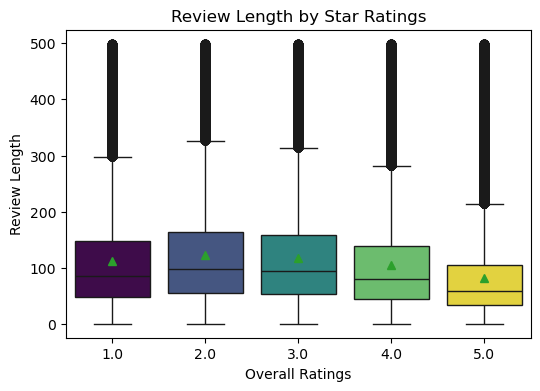

In [58]:
df_r = pa_reviews_filtered.copy()

df_r['text_length'] = df_r['text'].apply(lambda x: len(x.split(" ")))

df_r_temporary = df_r[df_r['text_length'] < 500].copy()

plt.figure(figsize=(6, 4))
sns.boxplot(x='stars', y='text_length', data=df_r_temporary, hue='stars',
            showmeans=True, palette='viridis', legend=False)
plt.title('Review Length by Star Ratings')
plt.xlabel('Overall Ratings')
plt.ylabel('Review Length')

plt.show()

In [59]:
print("With review text length:", df_r.shape)
df_r.head(3)

With review text length: (836679, 10)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42


#### Processed Review Text

In [61]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\woowe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\woowe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\woowe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\woowe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [63]:
### processed_review
def process_text(text):
    # Convert to Lowercase (0.1 marks)
    text_lower = text.lower()

    # Tokenization (0.1 marks)
    tokens = word_tokenize(text_lower)

    # Filter Alphabetic Tokens (0.1 marks)
    alphabetic_tokens = [word for word in tokens if re.match('^[a-zA-Z]+$', word)]

    # Remove Stopwords and Negation Words
    stop_words = set(stopwords.words('english'))
    # Negation words that should not be removed (0.1 marks)
    negation_words = ['not', 'no', 'never', "n't", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't",
                      "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "can't", "cannot"]
    # Create a list of tokens without stopwords and preserving negation words
    tokens_no_stopwords = [word for word in alphabetic_tokens if ((word not in stop_words) or (word in negation_words))]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    # Apply lemmatization to each token (0.1 marks)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens_no_stopwords]

    # Join the lemmatized tokens into a single processed text (0.1 marks)
    processed_text = ' '.join(lemmatized_words)

    return processed_text


In [64]:
df_r['processed_review'] = df_r['text'].apply(process_text)
print("With processed review:", df_r.shape)
df_r.head(3)

With processed review: (836679, 11)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42,tremendous service big shout douglas complemen...


In [65]:
# Download NLTK resources for part-of-speech tagging
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Define function to extract adjectives
def extract_adjectives(text):
    """
    Extracts adjectives from a given text.

    Parameters:
    - text (str): The input text from which adjectives will be extracted.

    Returns:
    - list: A list of adjectives extracted from the input text.
    """

    # Tokenize the input text
    tokens = word_tokenize(text)

    # Perform part-of-speech tagging on the tokens
    pos_tags = pos_tag(tokens) # (0.1 marks)

    # Extract adjectives based on their part-of-speech tags
    adjectives = [word for word, pos in pos_tags if pos in ["JJ"]] # (0.1 marks)

    # Return the list of extracted adjectives
    return adjectives

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\woowe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\woowe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [66]:
# Define function to generate Word Cloud for adjectives
def generate_word_cloud_adjectives(text, title):
    """
    Generates a Word Cloud visualization for adjectives extracted from the input text.

    Parameters:
    - text (str): The input text from which adjectives will be extracted and visualized.

    Returns:
    - None: Displays the generated Word Cloud plot.
    """

    # Extract adjectives using the previously defined extract_adjectives function
    adjectives = extract_adjectives(text)

    # Create a WordCloud object with specific configurations (0.1 marks)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(adjectives))

    # Plot the Word Cloud (0.1 marks)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [67]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\woowe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

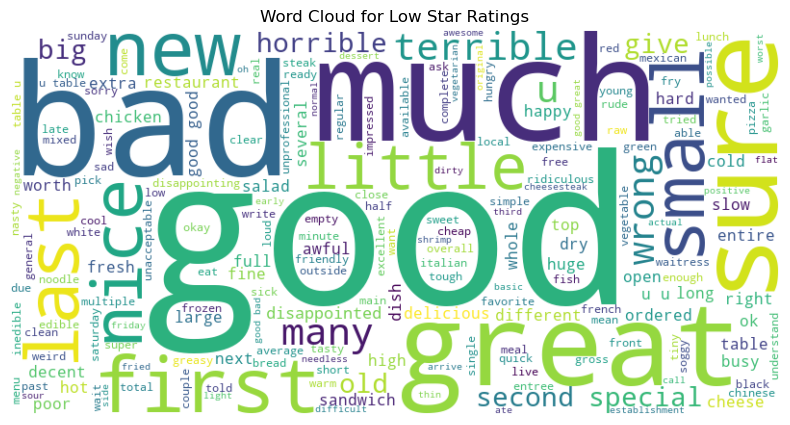

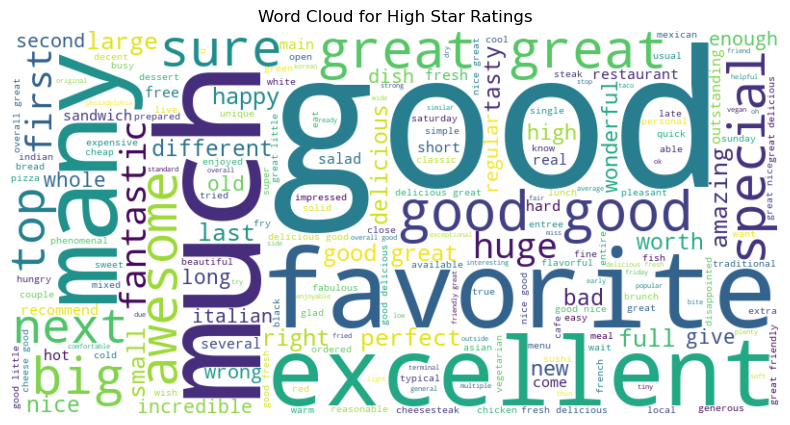

In [68]:
low_star_reviews = " ".join(df_r[df_r['stars'] < 3]['processed_review'])
high_star_reviews = " ".join(df_r[df_r['stars'] > 3]['processed_review'])

# Generate Word Clouds for adjectives in low and high star reviews (0.1 marks)
generate_word_cloud_adjectives(low_star_reviews, "Word Cloud for Low Star Ratings")
generate_word_cloud_adjectives(high_star_reviews, "Word Cloud for High Star Ratings")

#### Sum of votes for each review

In [70]:
df_r['sum_votes'] = df_r[['funny', 'useful', 'cool']].fillna(0).sum(axis=1)
print("With sum_votes:", df_r.shape)
df_r.head(3)

With sum_votes: (836679, 12)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...,0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...,2
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42,tremendous service big shout douglas complemen...,0


#### Decay Factor and Weighted Reviews

In [72]:
# Compute review age in days
baseline_date = datetime(2025, 1, 1)
df_r['review_age_days'] = (baseline_date - pd.to_datetime(df_r['date'])).dt.days

# Function to apply time decay
def apply_time_decay(df, decay_factor):
    df = df.copy()
    df.loc[:, 'review_weight'] = np.exp(-df['review_age_days'] / decay_factor)
    df.loc[:, 'weighted_stars'] = df['stars'] * df['review_weight']
    return df

# Split data into 80% train, 20% test
train_data, test_data = train_test_split(df_r, test_size=0.2, random_state=42)

# Cross-validation with 80% training data using decay factors in multiples of 365
decay_factors = [365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285, 3650, 4015, 4380, 4745, 5110, 5475, 5840, 6205, 6570, 6935, 7000]
cv_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for decay in decay_factors:
    mse_scores = []
    
    for train_index, val_index in kf.split(train_data):
        train_df, val_df = train_data.iloc[train_index].copy(), train_data.iloc[val_index].copy()
        
        # Apply time decay
        train_df = apply_time_decay(train_df, decay)
        val_df = apply_time_decay(val_df, decay)
        
        # Compute mean weighted rating per business
        business_avg_weighted_rating = train_df.groupby('business_id')['weighted_stars'].mean().fillna(0)
        
        # Predict validation ratings using the business averages
        val_df.loc[:, 'predicted_rating'] = val_df['business_id'].map(business_avg_weighted_rating).fillna(3)
        
        # Compute MSE
        mse = mean_squared_error(val_df['stars'], val_df['predicted_rating'])
        mse_scores.append(mse)
    
    # Store average MSE for this decay factor
    cv_results[decay] = np.mean(mse_scores)

# Find the best decay factor
best_decay = min(cv_results, key=cv_results.get)
print("Best Decay Factor:", best_decay)
print("Cross-validation MSE Scores:", cv_results)

# Apply the best decay factor to the dataset
df_r = apply_time_decay(df_r.copy(), best_decay)


Best Decay Factor: 7000
Cross-validation MSE Scores: {365: 16.0900634117175, 730: 15.018418645035414, 1095: 13.37725684400526, 1460: 11.721075114096099, 1825: 10.256569624112808, 2190: 9.022524188277927, 2555: 7.999868441118966, 2920: 7.155107471976992, 3285: 6.455278685652533, 3650: 5.872228250232003, 4015: 5.383144211371575, 4380: 4.969923501309356, 4745: 4.61829579919536, 5110: 4.317009688085525, 5475: 4.057160629612624, 5840: 3.8316620158876247, 6205: 3.634837408376575, 6570: 3.4621087144883864, 6935: 3.309758060544037, 7000: 3.284524107543247}


In [73]:
print("With time decay etc:", df_r.shape)
df_r.head(3)

With time decay etc: (836679, 15)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length,processed_review,sum_votes,review_age_days,review_weight,weighted_stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,101,decide eat aware going take hour beginning end...,0,2369,0.712890,2.138669
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,48,wow yummy different delicious favorite lamb cu...,2,3649,0.593757,2.968783
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,42,tremendous service big shout douglas complemen...,0,4208,0.548185,2.740924


In [74]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
Index: 836679 entries, 0 to 6990272
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   review_id         836679 non-null  object        
 1   user_id           836679 non-null  object        
 2   business_id       836679 non-null  object        
 3   stars             836679 non-null  float64       
 4   useful            836679 non-null  int64         
 5   funny             836679 non-null  int64         
 6   cool              836679 non-null  int64         
 7   text              836679 non-null  object        
 8   date              836679 non-null  datetime64[ns]
 9   text_length       836679 non-null  int64         
 10  processed_review  836679 non-null  object        
 11  sum_votes         836679 non-null  int64         
 12  review_age_days   836679 non-null  int64         
 13  review_weight     836679 non-null  float64       
 14  weighted

In [75]:
df_r.describe().round(2)

,stars,useful,funny,cool,date,text_length,sum_votes,review_age_days,review_weight,weighted_stars
count,836679.00,836679.00,836679.00,836679.00,836679,836679.00,836679.00,836679.00,836679.00,836679.00
mean,3.79,1.05,0.34,0.49,2016-09-25 13:12:32.503128832,103.46,1.88,3019.01,0.66,2.50
min,1.00,0.00,0.00,0.00,2005-02-16 04:06:26,1.00,0.00,1077.00,0.35,0.36
25%,3.00,0.00,0.00,0.00,2014-08-01 07:28:55,42.00,0.00,2092.00,0.58,1.77
50%,4.00,0.00,0.00,0.00,2017-03-06 22:36:45,75.00,1.00,2857.00,0.66,2.60
75%,5.00,1.00,0.00,0.00,2019-04-10 12:18:30.500000,133.00,2.00,3805.00,0.74,3.32
max,5.00,224.00,227.00,163.00,2022-01-19 19:46:34,3079.00,504.00,7258.00,0.86,4.29
std,1.36,2.48,1.39,1.84,NaN,93.59,5.29,1185.81,0.11,1.02


# Save dataframes to CSV

In [77]:
# Save dataframes to CSV
df_r.to_csv("df_r.csv", index=False)
restaurants.to_csv("restaurants.csv", index=False)
filtered_users.to_csv("filtered_users.csv", index=False)

print("CSV files saved: df_r.csv, restaurants.csv, filtered_users.csv")

CSV files saved: df_r.csv, restaurants.csv, filtered_users.csv
